# Notebook to explore the BOLDMoments data

**Data location:** /oliva/blahner/BOLDMoments/preprocessed_data/responses.

Reminder that reconstruction should be done per subject. Subject 1 is good. 
To get started, use: ./sub01/testing/X_TRavg-56789testing.pkl, where X is either the ROI name or WB (whole brain). The contents of the pkl file is a dict with keys "test_data" and "train_data" with shapes (num_videos, num_repetitions, num_voxels). Feel free to average over repetitions. You can also find the metadata json file and video stimuli in /oliva/datasets/BOLDMoments/metadata.


For time-resolved brain activity, use /sub01/testing/X_TRavg-Ytesting.pkl where Y is 5, 6, 7, 8, or 9. Don't worry about numbers 1-4. But I'd first start with the 56789avg to make sure we can get some reconstruction.


FAQ
1. **Training vs testing folder?**
The data in the “testing” folder folder contains keys of “test_data” and “train_data”, so everything you need is in there. The reason why we have a dedicated “training” folder was for the challenge, where we didn’t want to release any test data. The “train_data” key in the “testing” folder is an exact copy of the data in the “training” folder.
2. What are the different brain areas?
PPA is scene-selective, LOC is object selective, OFA is face selective. PFop and PFt don’t have as nice a functional description, but are thought to be involved in a action mirroring network. More info will be available soon.
3. What does time resolved mean?
By time-resolved, we mean samples from different time points along the BOLD signal. There is not a straightforward mapping between time points along the BOLD signal and time points in the video. Different brain regions integrate information over time differently. So lots of open questions there, but in general we show that early (late) video frames correspond to early (late) samples along the BOLD signal

In [4]:
import sys
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# Load pkl file with moments data

with open("./data/sub01/testing/WB_TRavg-56789_testing.pkl", "rb") as f:
    data = pkl.load(f)

print(data)

{'noise_ceiling': array([ 0.18175637,  0.23454077,  0.34508738, ...,  0.1399355 ,
        0.04457096, -0.06857824]), 'p_values': array([0.0990099 , 0.01980198, 0.00990099, ..., 0.22772277, 0.36633663,
       0.67326733]), 'nan_indices': array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 5.15031e+05,
       5.15032e+05, 5.15033e+05]), 'train_data': array([[[ 1.00652658,  0.5014861 ,  0.88428398, ..., -0.36216733,
         -1.13355098, -0.5212484 ],
        [ 0.19570085,  0.94794238, -0.02165601, ..., -0.30541688,
          0.00941362,  0.13845932],
        [ 0.59445705,  0.44530229,  0.0467085 , ..., -0.95434785,
          0.09860132, -0.12931361]],

       [[-0.22539308,  0.01786901,  0.49588254, ...,  0.27360575,
          0.15266588, -0.34826202],
        [ 0.93116471,  1.12381873,  0.74230157, ...,  0.26379817,
          0.11740854,  0.70703196],
        [-0.83114302, -1.14896191,  0.76933264, ..., -0.33627207,
         -0.11313701,  0.3708633 ]],

       [[ 0.33401699,  0.46372998,

In [32]:
print(data.keys())

dict_keys(['noise_ceiling', 'p_values', 'nan_indices', 'train_data', 'test_data'])


In [33]:
# View (num_videos, num_repetitions, num_voxels) for each key
print(data['test_data'].shape)
print(data['train_data'].shape)
print(data['noise_ceiling'].shape)
print(data['p_values'].shape)


(102, 10, 18320)
(1000, 3, 18320)
(98273,)
(98273,)


(102, 18320)


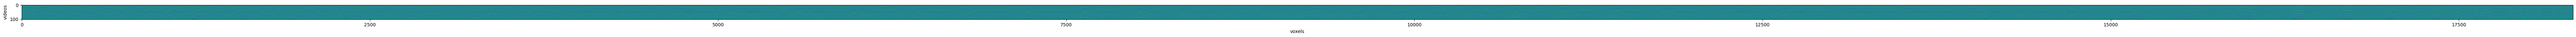

In [37]:
# Plot average value per voxel

def avg_value_per_voxel(data: dict, average_over: str='repetitions') -> None:
    """
    Plot average value per voxel, averaged across average_over (repetitions, frames or voxels)
    """

    if average_over == 'videos':
        dim = 0; ylabel='repetitions'; xlabel='voxels'
    elif average_over == 'repetitions':
        dim = 1; ylabel='videos'; xlabel='voxels'
    elif average_over == 'voxels':
        dim = 2; ylabel='videos'; xlabel='repetitions'
    else:
        raise ValueError('average_over must be one of "videos", "repetitions" or "voxels"')

    avg_per_voxel = np.mean(data['test_data'], axis=dim)
    print(avg_per_voxel.shape)
    plt.figure(figsize=(100, 120))
    plt.imshow(avg_per_voxel, cmap='viridis')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


avg_value_per_voxel(data, average_over='repetitions')


In [1]:
def load_all_fmri_for_subject(path_to_subject_data: str) -> dict:
    """
    Load all fmri data for a subject into a dict with brain locations as keys
    """

    fmri_data = {}

    for p in os.listdir(path_to_subject_data):
        if '56789' not in p: continue
        
        brain_region = p.split('_')[0]

        with open(os.path.join(path_to_subject_data, p), 'rb') as f:
            data = pkl.load(f)
            fmri_data[brain_region] = data

    return fmri_data

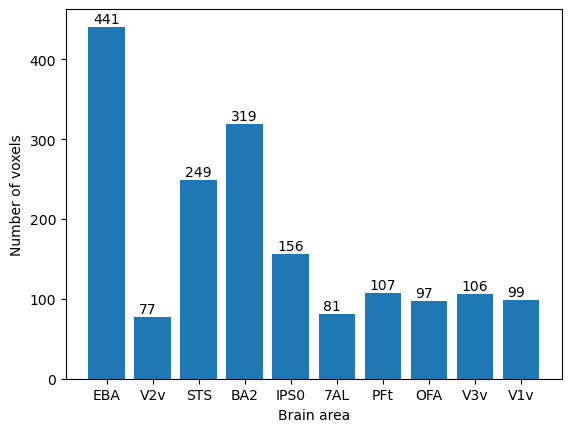

In [14]:
# Bar chart with number of voxels for each brain area

def num_voxels_per_brain_area(path: str) -> None:

    fmri_data = load_all_fmri_for_subject(path)

    voxels = {}
    for brain_area, data in fmri_data.items():
        if brain_area == 'WB': continue
        voxels[brain_area] = data['test_data'].shape[2]

    plt.bar(voxels.keys(), voxels.values())
    plt.xlabel('Brain area')
    plt.ylabel('Number of voxels')
    # Show numbers on top of bars
    for i, v in enumerate(voxels.values()):
        plt.text(i - 0.3, v + 5, str(v))
    plt.show()

num_voxels_per_brain_area("./data/sub01/testing")
        